### Neural network + Gradient of inputs
A example of how to build a neural network which consumes `data` and `gradient of the data` to fit the neural network. 


In [5]:
import math
import torch
from torch import nn
import matplotlib.pylab as plt

In [10]:
def gradient(y, x, grad_outputs=None):
    """
    Compute dy/dx @ grad_outputs
    Ref: https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/14
    """
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
        grad = torch.autograd.grad(y, [x], grad_outputs = grad_outputs, create_graph=True)[0]
    return grad


In [11]:
class NeuralNetwork(nn.Module):
    """
    A dense neural network.
    """
    def __init__(self, input_size=1):
        super(NeuralNetwork, self).__init__()
        self.layer_stack = nn.Sequential(
          nn.Linear(input_size, 10),
          nn.Tanh(),
          nn.Linear(10, 10),
          nn.Tanh(),
          nn.Linear(10, 1),
          nn.Identity(),
        )

    def forward(self, x):
        return self.layer_stack(x)
    
    
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (layer_stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): Identity()
  )
)


In [12]:
def function(x):
    return torch.sum(torch.sin(x), dim=1).view(-1, 1)

def get_samples(n, requires_grad=True, factor=4):
    return torch.rand(n, 1, requires_grad=requires_grad)*math.pi*factor

x_train = get_samples(1000)
y_train = function(x_train)
dy_train = gradient(y_train, x_train)

x_val = get_samples(100)
y_val = function(x_val)
dy_val = gradient(y_val, x_val)

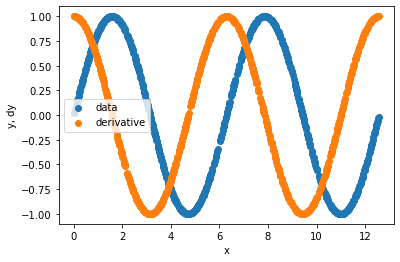

In [13]:
plt.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="data")
plt.scatter(x_train.detach().numpy(), dy_train.detach().numpy(), label="derivative")
plt.xlabel("x"); plt.ylabel("y, dy"); plt.legend();

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train(model, optimizer, loss_fn, epochs=5000):
    """
    Train input model using provided optimizer, loss function, and data.
    """
    for epoch in range(epochs):
        # Training 
        training_loss = 0.0
        model.train()
        optimizer.zero_grad()
        y =  model(x_train)
        dy = gradient(y, x_train)
        loss = criterion(y, y_train) #+ criterion(dy, dy_train)
        loss.backward(retain_graph=True)
        optimizer.step()
        training_loss += loss.data.item()
        
        # Validation
        valid_loss = 0.0
        model.eval()
        y =  model(x_val)
        dy = gradient(y, x_val)
        loss = criterion(y, y_val) #+ criterion(dy, dy_val)
        valid_loss += loss.data.item()
        
        # Print
        if epoch==0 or (epoch+1) % 500 == 0:
            print(f'Epoch: [{epoch+1}/{epochs}], Training Loss: {training_loss:.8f}, Valid Loss: {valid_loss:.8f}')

In [15]:
train(model, optimizer, criterion)

Epoch: [1/5000], Training Loss: 0.56747615, Valid Loss: 0.51985687
Epoch: [500/5000], Training Loss: 0.35790092, Valid Loss: 0.40045848
Epoch: [1000/5000], Training Loss: 0.27421087, Valid Loss: 0.31106651
Epoch: [1500/5000], Training Loss: 0.07308057, Valid Loss: 0.07419117
Epoch: [2000/5000], Training Loss: 0.04668491, Valid Loss: 0.04497937
Epoch: [2500/5000], Training Loss: 0.03495444, Valid Loss: 0.03224115
Epoch: [3000/5000], Training Loss: 0.01365870, Valid Loss: 0.01197279
Epoch: [3500/5000], Training Loss: 0.00103311, Valid Loss: 0.00089578
Epoch: [4000/5000], Training Loss: 0.00041550, Valid Loss: 0.00039356
Epoch: [4500/5000], Training Loss: 0.00021986, Valid Loss: 0.00022668
Epoch: [5000/5000], Training Loss: 0.00013455, Valid Loss: 0.00014343


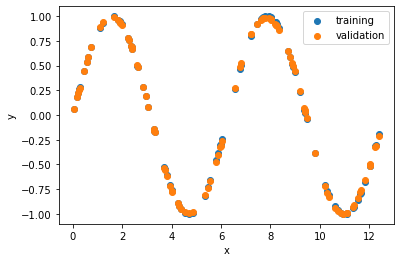

In [16]:
plt.scatter(x_val.detach().numpy(), y_val.detach().numpy(), label="training")
plt.scatter(x_val.detach().numpy(), model(x_val).detach().numpy(), label="validation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend();

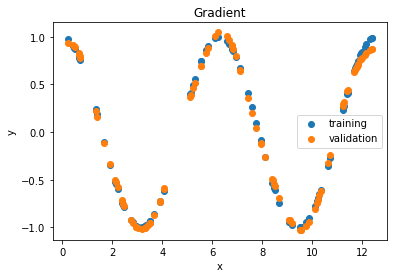

In [17]:
x = get_samples(100, True)
plt.scatter(x.detach().numpy(), gradient(function(x), x).detach().numpy(), label="training")
plt.scatter(x.detach().numpy(), gradient(model(x), x).detach().numpy(), label="validation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.title("Gradient");